# Maxcut problem

## **Step 0**: Setup

In [1]:
# General imports
import math
import numpy as np

# Qiskit ansatz circuits
from qiskit.circuit.library import RealAmplitudes

# Qiskit primitives
from qiskit.primitives import Estimator as QiskitEstimator
from qiskit_aer.primitives import Estimator as AerEstimator
from qiskit.primitives import Sampler as QiskitSampler
from qiskit_aer.primitives import Sampler as AerSampler

# Qiskit runtime
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import Estimator, Sampler, Session

# quadratic_program
from quadratic_program import QuadraticProgram

# Docplex - classical description of optimization problems
from docplex.mp.model import Model

# translations
from translators import docplex_mp_to_qp
from translators import qubo_to_sparse_pauli_op

# workflows 
from workflows import QuadraticProgramPostprocess, QuadraticProgramConverter

# SPSA
from spsa import minimize_spsa

# rustworkx graph library
import rustworkx as rs
from rustworkx.visualization import mpl_draw

## Load the Runtime (if using)

In [2]:
service = QiskitRuntimeService()

In [3]:
backend = service.get_backend('ibm_nazca')


## **Step 1** Map the problem to a Quantum Native format (Set of Operators, and a set of Quantum Circuits)

Specify optimization problem using docplex and convert to Quadratic Unconstained Binary Opimization (QUBO) problem that can be cast as an Ising Hamiltonian suitable for a quantum solution.

In [4]:
def random_adjacency_graph(N, density=0.5):
    """Build random adjacency graph of a given density

    Parameters:
        N (int): Matrx dimension
        density (float): Density of non-zero elements, default=0.5

    Returns:
        ndarray: Adjacency matrix as NumPy array
    """
    off_elems = N*(N-1)//2
    num_elems = math.ceil(off_elems * density)
    inds = np.sort(np.random.choice(off_elems, size=num_elems, replace=False))

    M = np.zeros((N, N), dtype=float)
    for k in inds:
        i = N - 2 - int(math.sqrt(-8*k + 4*N*(N-1)-7)/2 - 0.5)
        j = (k + i + 1 - N*(N-1)//2 + (N-i)*((N-i)-1)//2)
        M[i,j] = 1

    M = M + M.T
    return M

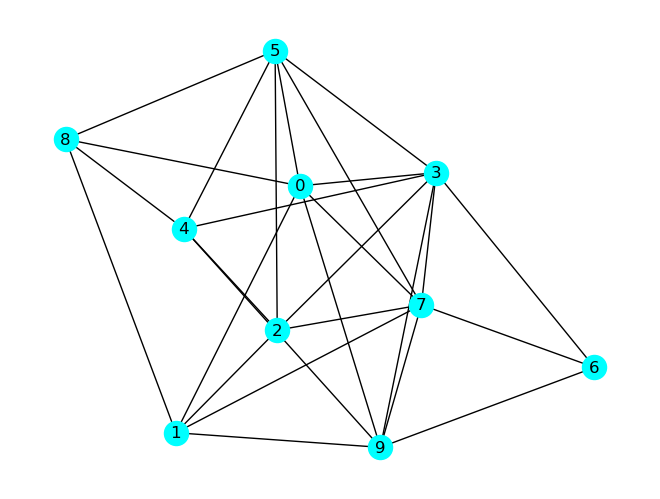

In [5]:
N = 10
density = 0.6
M = random_adjacency_graph(N, density)

G = rs.PyGraph.from_adjacency_matrix(M)
mpl_draw(G, with_labels=True, node_color='cyan')

In [6]:
mdl = Model(name="Max-cut")
x = {i: mdl.binary_var(name=f"x_{i}") for i in range(G.num_nodes())}
objective = mdl.sum(w * x[i] * (1 - x[j]) + w * x[j] * (1 - x[i]) for i, j, w in G.weighted_edge_list())
mdl.maximize(objective)
#print(mdl.export_as_lp_string())

### Convert to our `QuadraticProgram` format

In [7]:
qp = docplex_mp_to_qp(mdl)
#print(qp.prettyprint())

### Classical transformation to QUBO problem and Ising Hamiltonian

In [8]:
quadratic_transformer = QuadraticProgramConverter()
qubo = quadratic_transformer.run(qp)
#print(qubo.prettyprint())

In [9]:
hamiltonian, offset = qubo_to_sparse_pauli_op(qubo)

### Select ansatz circuit from circuit library

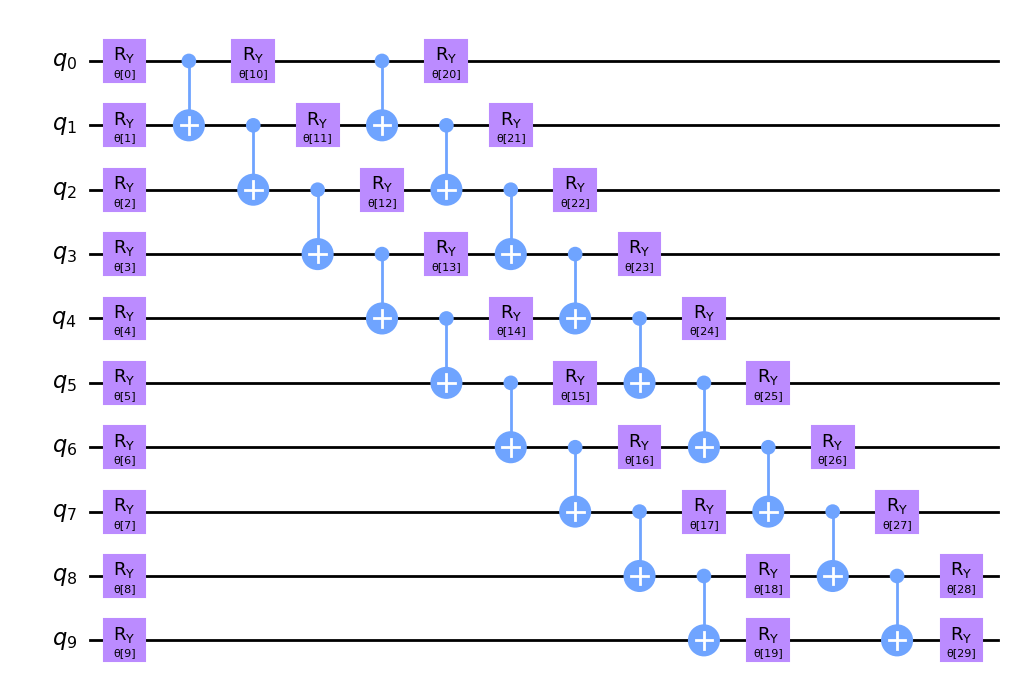

In [10]:
ansatz = RealAmplitudes(hamiltonian.num_qubits, entanglement='linear', reps=2)
ansatz.decompose().draw('mpl')

## **Step 2**: Optimize the circuits and the operators to be measured

In [22]:
from qiskit.transpiler import PassManager
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.transpiler.passes import ALAPScheduleAnalysis, PadDynamicalDecoupling
from qiskit.circuit.library import XGate

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)
pm.scheduling = PassManager(
    [
        ALAPScheduleAnalysis(target=target), 
        PadDynamicalDecoupling(target=target, dd_sequence=[XGate(), XGate()])
    ]
)

ansatz_ibm = pm.run(ansatz)

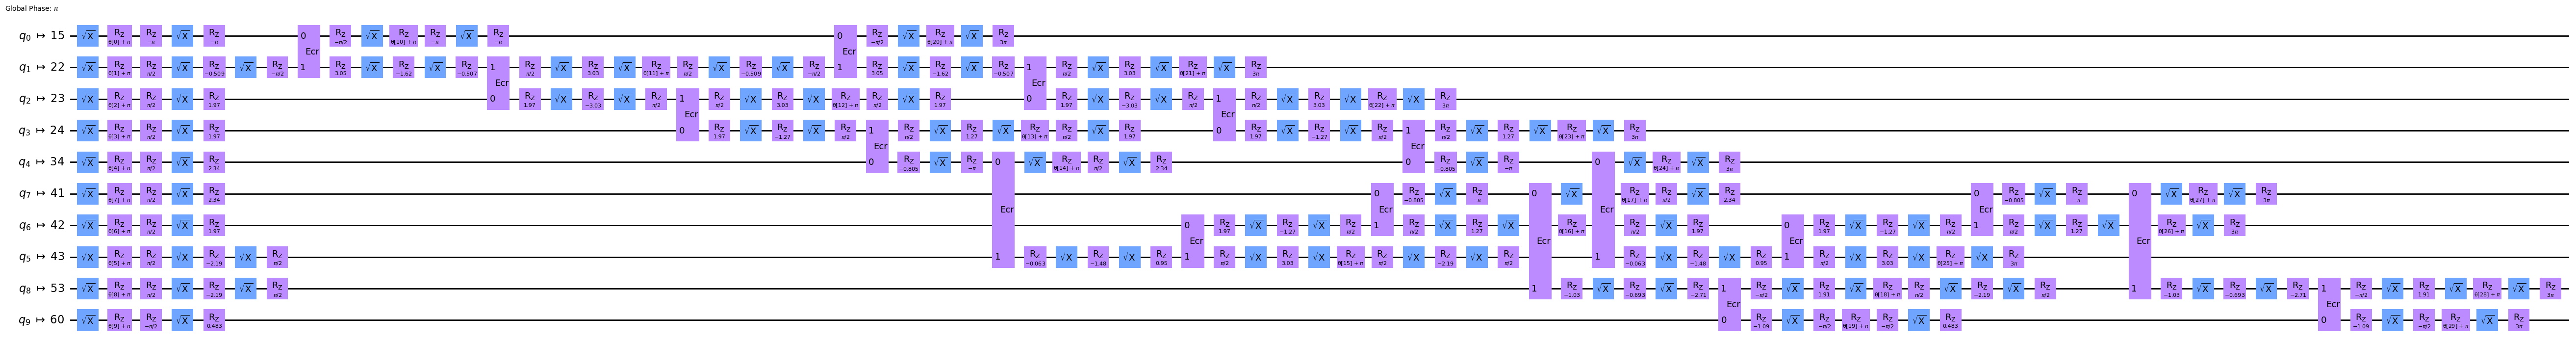

In [23]:
ansatz_ibm.draw('mpl', idle_wires=False, fold=-1)

In [24]:
from permute_sparse_pauli_op import permute_sparse_pauli_op

layout = ansatz_ibm.layout.initial_layout
hamiltonian_ibm = permute_sparse_pauli_op(hamiltonian, layout, ansatz.qubits)

In [29]:
# Obtain index of the physical qubits to which the virtual qubits are mapped to 
q_vir, q_phy = [], []
for k in range(backend.num_qubits):
    if (layout[k].index in range(N)) and (layout[k].register.name=='q'):
        q_vir.append(layout[k].index)
        q_phy.append(k)
qubit_map = dict(zip(q_vir, q_phy))
print(qubit_map)
q_phy_order = [qubit_map[k] for k in range(N)]
print(q_phy_order)

{0: 15, 1: 22, 2: 23, 3: 24, 4: 34, 7: 41, 6: 42, 5: 43, 8: 53, 9: 60}
[15, 22, 23, 24, 34, 43, 42, 41, 53, 60]


/var/folders/3p/d4fzjcrx4lsfbs0n99gbkf640000gn/T/ipykernel_81601/1986260277.py:4: DeprecationWarning: The property ``qiskit.circuit.bit.Bit.index`` is deprecated as of qiskit-terra 0.17. It will be removed no earlier than 3 months after the release date. Instead, use :meth:`~qiskit.circuit.quantumcircuit.QuantumCircuit.find_bit` to find all the containing registers within a circuit and the index of the bit within the circuit.
  if (layout[k].index in range(N)) and (layout[k].register.name=='q'):
/var/folders/3p/d4fzjcrx4lsfbs0n99gbkf640000gn/T/ipykernel_81601/1986260277.py:4: DeprecationWarning: The property ``qiskit.circuit.bit.Bit.register`` is deprecated as of qiskit-terra 0.17. It will be removed no earlier than 3 months after the release date. Instead, use :meth:`~qiskit.circuit.quantumcircuit.QuantumCircuit.find_bit` to find all the containing registers within a circuit and the index of the bit within the circuit.
  if (layout[k].index in range(N)) and (layout[k].register.name=='

## **Step 3**: Execute using a quantum primitive function (estimator or sampler)

### Standard cost function definition

In [25]:
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    cost = estimator.run(ansatz, hamiltonian, parameter_values=params).result().values[0]
    return cost

### Setup estimator and sampler instances

In [26]:
#session = Session(backend=backend)
#estimator = Estimator(session=session, options={"shots": int(1e4)})
#sampler = Sampler(session=session, options={"shots": int(1e4)})
#estimator = QiskitEstimator(options={"shots": int(1e4)})
#sampler = QiskitSampler(options={"shots": int(1e4)})

estimator = AerEstimator()
sampler = AerSampler()

### Perform minimization

In [27]:
x0 = 2*np.pi*np.random.random(size=ansatz_ibm.num_parameters)
res = minimize_spsa(cost_func, x0, args=(ansatz_ibm, hamiltonian_ibm, estimator), maxiter=5)
res

     fun: -0.19140625
 message: 'Optimization terminated successfully.'
    nfev: 10
     nit: 5
 success: True
       x: array([ 7.6812002 ,  9.62806979, -2.95779429,  5.60844854, -2.88715914,
       -4.99482626, -2.91151657,  1.06051581,  3.65781655,  1.7989815 ,
        1.40112732,  1.52930524,  6.65264892,  4.52139724,  5.68184716,
        6.59423151,  1.86324833, -2.7569364 ,  4.42197608,  4.45646734,
        1.73056218,  2.87873402, -1.82004086,  6.63284666,  5.49572729,
       -0.8215816 , 10.73615873,  3.92975547, -3.59395711,  9.73605827])

### Computute distribution at found minimum

In [30]:
from qiskit.circuit.classicalregister import ClassicalRegister

# Add measurements only for the active qubits in a proper order
cr = ClassicalRegister(N, 'cr')
qc = ansatz_ibm.assign_parameters(res.x)
qc.add_register(cr)
qc.measure(q_phy_order, range(N))
samp_dist = sampler.run(qc, shots=int(1e4)).result().quasi_dists[0]
# Close the session since we are now done with it
#session.close()

## **Step 4**: Post-processing of the results to return either a plot or the answer
Transform quantum solution and convert back into classical variable space

In [31]:
solution = QuadraticProgramPostprocess(qubo, quadratic_transformer).run(samp_dist)
solution

array([0., 0., 1., 1., 0., 0., 0., 1., 1., 1.])

## Intepretation of solution

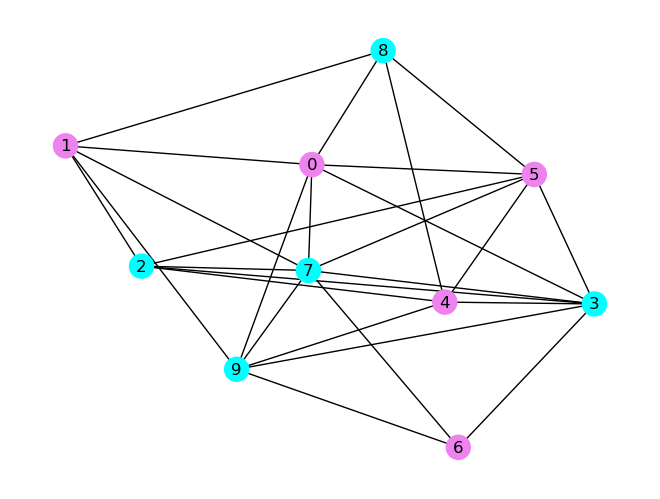

In [32]:
mpl_draw(G, with_labels=True, 
         node_color=['cyan' if kk else 'violet' for kk in solution])